In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
import os
#import math
#from scipy.sparse import csr_matrix

For understanding cell to cell heterogeneity, it is important to identify cell populations across our dataset.There are two approeaches when it comes to explaining cell to cell variation in our dataset. The most common approach is to **cluster cells** into groups with similar expression profiles usign **grpah-based clsutering**. This strategy [assumes that data is composed of biologically distinct groups such as discrete cell types or states and labels these with a discrete variable—the cluster index](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1663-x). A k-nearest neightbour graph (KNN) can be used to represent cells as nodes connected by similarity through edges. KNN algotihms compute the euclidean distances on reduced expression sapce for all cells and connects each cell with its *k* most similar cells.

The other main approach is to **infer the pseudotemporal orderings or trajectories of cells**. This assumes that data lie on a connected manifold and labels cells with a continuous variable—the distance along the manifold. Underlying trajectories can be cyclic, linear, a tree or, most generally, a graph. This strategy is useful in biological processes were cells traverse a continuous space of cellular state (phenotypes), such as development, dose response, and disease progression.

### Clustering

As usual, the selection of proper methods and algorithms is very context dependant, and we should ask questions such as whether we are interested in detection of major cell types or specific cell subtypes. Here, we are going to use the **Leiden algorithm** to detect dense regions in the KNN-graph which will result in the clustering of putative cell types based on this clustering method. This algorithm is implemented by **scanpy**.

Let's load our dimensionaly reduced dataset:

In [6]:
pro_file = os.path.dirname(os.getcwd()) + "/dimensionality_reduction.h5ad"

In [7]:
adata = sc.read(pro_file)

We will now build the graph based on the first 30 PCs, as these are the ones which captures the most variation. We will discard the rest PCs as they capture little variation, but remember again, this is very context dependant. But in general, the first PCs capture the most interesting variation:

In [9]:
sc.pp.neighbors(adata, n_pcs=30)

And we call the Leiden algorithm:

In [10]:
sc.tl.leiden(adata)

/tmp/ipykernel_73/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


``leiden()`` function from **scanpy** has a parameter called ``resolution``, which controls the coarseness of the clustering (from 0 to 1). Higher resolutions will give a higher number of cell populations, while lower resolutions will result in fewer communities. It is probably a good idea to try different reslutions and compare. The default resolution is 1. Again, this is very context dependant.

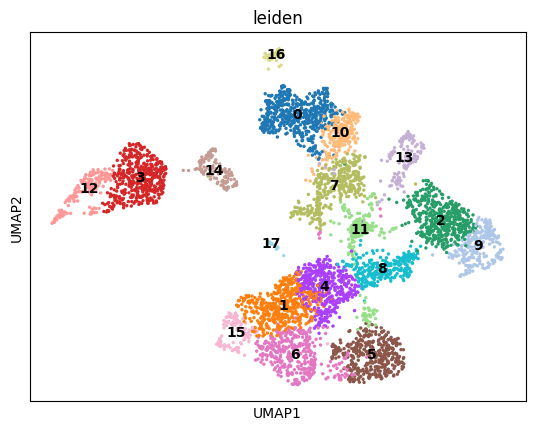

In [15]:
sc.pl.umap(adata, color="leiden", legend_loc="on data")

One important note regarding UMAP is that since this is a 2D representation of high dimensional space, and so distances between clusters here might not be at all representative. Therefore, it is not a good idea to interpret these distances as similar to the ones present in the high dimensional space.

### Annotation

The next step is to annotate cell types. Instead of classifying cells individually, we will find the cell identities of the identfied clusters. A cell type could be defined as cellular phenotype that has a characteristic expression profile different from other cell types, with specific functions and that is robustly classified across datasets. There is not a strict definition for cell types, and this might change as reasearch and sequencing technologies develop. For insntace, in the past cell types were classified according to their function, morphology and location, now single cell technologies offer much higher resolutions for indentifying cell types based on their molecular profile [check](https://www.cell.com/action/showPdf?pii=S0092-8674%2822%2900783-8).

It seems cell types identification can be manual or automatic. [A three-step approach is recommended that leverages automated annotation, followed by expert manual annotation and a last step of verification to obtain the ideal annotation result](https://www.nature.com/articles/s41576-023-00586-w).

#### Manual Annotation

Firstly we are going to annotate the clusters in our dataset according to the [paper](), which is contains the data we are using as reference for building this pipeline. There is a supplementary table which contains the expected cell types and the markers to annotate them. Let's load the table:

In [7]:
#!pip install openpyxl==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.3/251.3 kB 4.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [8]:
excel = os.path.dirname(os.getcwd()) + "/mmc4.xlsx"
cell_markers = pd.read_excel(excel)

In [9]:
cell_markers

,HSC,Progenitor,GMP,Monocyte,Erythroid,B-Lymphoid,T-Lymphoid
0,AVP,SPINK2,PRTN3,S100A9,HBD,DNTT,CD3E
1,CRHBP,C1QTNF4,ELANE,S100A12,HBB,VPREB1,IL7R
2,HOPX,NUCB2,MPO,S100A8,FCER1A,VPREB3,LTB
3,SPINK2,IGFBP7,AZU1,TYROBP,APOC1,IGLL1,CD3D
4,NRIP1,AC002454.1,CTSG,FCN1,CYTL1,CD9,IL32
5,ANKRD28,NAP1L1,RNASE2,VCAN,CNRIP1,CD79B,KLF2
6,CYTL1,HOPX,MS4A3,CD14,GATA2,AKAP12,CD7
7,C6orf48,CDK6,RETN,CTSS,TMEM14C,ARPP21,CD3G
8,IDS,FABP5,SRGN,S100A11,TPM1,MZB1,LCK
9,EGFL7,ANKRD28,CST7,FCER1G,MYC,CD79A,EVL
